<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/009_RNN_ECG_Classification_PyTorch_0801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download from Google Drive
!pip install --upgrade gdown
!gdown --id 18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO
To: /content/ecg-kaggle.zip
100% 2.72M/2.72M [00:00<00:00, 260MB/s]


In [ ]:
!unzip ecg-kaggle.zip

Archive:  ecg-kaggle.zip
   creating: kaggle/
  inflating: __MACOSX/._kaggle       
  inflating: kaggle/Icon             
  inflating: __MACOSX/kaggle/._Icon  
  inflating: kaggle/test.csv         
  inflating: __MACOSX/kaggle/._test.csv  
  inflating: kaggle/train.csv        
  inflating: __MACOSX/kaggle/._train.csv  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import torch
import torch.nn as nn
from tqdm.auto import tqdm

torch.__version__

'2.0.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Data

num_classes: 5

column 0 ~ column 186 : signal

column 187: label

In [ ]:
df = pd.read_csv('kaggle/train.csv')
num_classes = 5

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train, df_val = train_test_split(df,
                                    random_state=5566,
                                    # keep class distibution
                                    stratify=df.iloc[:, -1].tolist(),
                                    test_size=0.3)

idx:  769


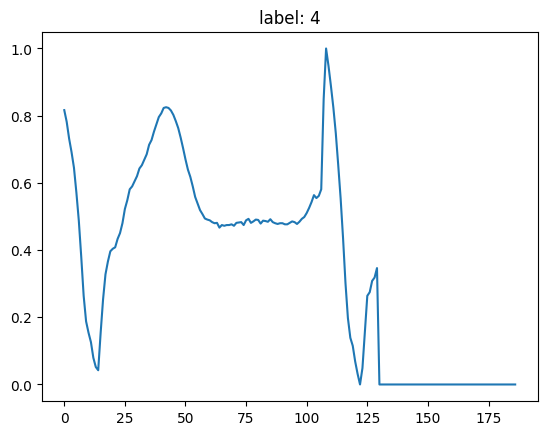

In [ ]:
# visualize data
idx = np.random.randint(0, len(df_train))
print("idx: ", idx)
plt.title(f'label: {int(df_train.iloc[idx, -1])}')
plt.plot(df_train.iloc[idx, :-1].tolist())
plt.show()

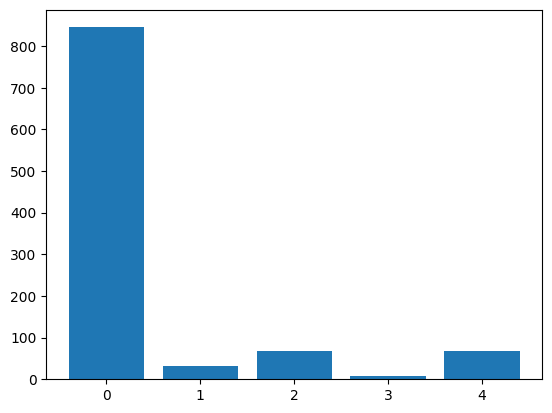

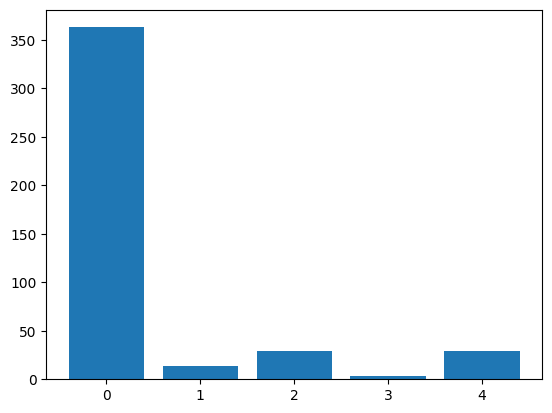

In [ ]:
# draw class distribution
def plot_distibution(df):
    values, counts = np.unique(df.iloc[:, -1].tolist(), return_counts=True)
    plt.bar(range(len(values)), counts)
    plt.show()

plot_distibution(df_train)
plot_distibution(df_val)

#### Dataset

In [ ]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        signal = self.df.iloc[idx, :-1].tolist() # (186, )
        label = self.df.iloc[idx, -1]

        # add channel dim
        signal = torch.tensor(signal, dtype=torch.float).unsqueeze(0) # (1, 186)
        label = torch.tensor(label, dtype=torch.long)

        # preprocess
        signal = (signal - signal.mean()) / signal.std()

        return signal, label

train_ds = ECGDataset(df_train)
val_ds = ECGDataset(df_val)

In [ ]:
signal, label = train_ds[0]
signal.shape, label.shape, label

(torch.Size([1, 187]), torch.Size([]), tensor(0))

In [ ]:
# Dataloader
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=BATCH_SIZE)

In [ ]:
for data in train_loader:
    signals, labels = data
    print(signals.shape, labels.shape)
    break

torch.Size([16, 1, 187]) torch.Size([16])


#### Model

In [ ]:
class ECGModel(nn.Module):
    def __init__(self, num_classes, in_dim, out_dim, layers, bidirectional=False):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_size=in_dim,
                                     hidden_size=out_dim,
                                     num_layers=layers,
                                     bidirectional=bidirectional
                                     )
        D = 2 if bidirectional else 1
        self.classifier = nn.Linear(D*out_dim, num_classes)

    def forward(self, inputs):
        # swap axes: (N, in_dim, L) -> (L, N, in_dim)
        inputs = inputs.permute(2, 0, 1)

        # features: (L, N, out_dim)
        features, (hn, cn) = self.encoder(inputs)

        # Method 1: Get the last step feature for each data in a batch
        feature = features[-1, :, :] # (N, out_dim)

        # Method 2: take average of all time steps
        # feature = features.mean(axis=0)

        output = self.classifier(feature) # (N, num_classes)

        return output

model = ECGModel(num_classes=num_classes,
                 in_dim=1,
                 out_dim=64,
                 layers=2,
                 bidirectional=True)

In [ ]:
inputs = torch.rand(BATCH_SIZE, 1, 186)
outputs = model(inputs)

outputs.shape

torch.Size([16, 5])

#### Train

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 0.8674, train_acc: 0.774         val_loss: 0.7042, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 0.6691, train_acc: 0.828         val_loss: 0.7064, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.6655, train_acc: 0.828         val_loss: 0.7007, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.6645, train_acc: 0.828         val_loss: 0.7042, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.6646, train_acc: 0.828         val_loss: 0.7019, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.6517, train_acc: 0.828         val_loss: 0.7556, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.6665, train_acc: 0.828         val_loss: 0.6995, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.6577, train_acc: 0.828         val_loss: 0.7063, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.6551, train_acc: 0.828         val_loss: 0.7055, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.6485, train_acc: 0.828         val_loss: 0.7453, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.6467, train_acc: 0.828         val_loss: 0.6914, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.6361, train_acc: 0.828         val_loss: 0.6856, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.6228, train_acc: 0.828         val_loss: 0.6788, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.6043, train_acc: 0.828         val_loss: 0.6705, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.6321, train_acc: 0.828         val_loss: 0.6918, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.6015, train_acc: 0.828         val_loss: 0.6603, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.5955, train_acc: 0.828         val_loss: 0.6591, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.5807, train_acc: 0.828         val_loss: 0.7096, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.6151, train_acc: 0.828         val_loss: 0.6823, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.5870, train_acc: 0.828         val_loss: 0.6492, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.5942, train_acc: 0.828         val_loss: 0.6992, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0021         train_loss: 0.5961, train_acc: 0.828         val_loss: 0.6728, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0022         train_loss: 0.5858, train_acc: 0.828         val_loss: 0.6496, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0023         train_loss: 0.5811, train_acc: 0.828         val_loss: 0.6505, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0024         train_loss: 0.5831, train_acc: 0.828         val_loss: 0.6710, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0025         train_loss: 0.5855, train_acc: 0.828         val_loss: 0.6689, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0026         train_loss: 0.5834, train_acc: 0.828         val_loss: 0.6502, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0027         train_loss: 0.5764, train_acc: 0.828         val_loss: 0.6606, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0028         train_loss: 0.5756, train_acc: 0.828         val_loss: 0.6472, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0029         train_loss: 0.5721, train_acc: 0.828         val_loss: 0.6515, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0030         train_loss: 0.5807, train_acc: 0.828         val_loss: 0.6622, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0031         train_loss: 0.5776, train_acc: 0.828         val_loss: 0.6417, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0032         train_loss: 0.5765, train_acc: 0.828         val_loss: 0.6448, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0033         train_loss: 0.5711, train_acc: 0.828         val_loss: 0.6463, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0034         train_loss: 0.5725, train_acc: 0.828         val_loss: 0.6454, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0035         train_loss: 0.5748, train_acc: 0.828         val_loss: 0.6383, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0036         train_loss: 0.5720, train_acc: 0.828         val_loss: 0.6383, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0037         train_loss: 0.5714, train_acc: 0.823         val_loss: 0.6437, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0038         train_loss: 0.5701, train_acc: 0.828         val_loss: 0.6400, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0039         train_loss: 0.5710, train_acc: 0.828         val_loss: 0.6394, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0040         train_loss: 0.5718, train_acc: 0.828         val_loss: 0.6498, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0041         train_loss: 0.5720, train_acc: 0.828         val_loss: 0.6516, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0042         train_loss: 0.5709, train_acc: 0.828         val_loss: 0.6447, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0043         train_loss: 0.5740, train_acc: 0.828         val_loss: 0.6532, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0044         train_loss: 0.5691, train_acc: 0.828         val_loss: 0.6514, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0045         train_loss: 0.5680, train_acc: 0.828         val_loss: 0.6368, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0046         train_loss: 0.5672, train_acc: 0.825         val_loss: 0.6333, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0047         train_loss: 0.5714, train_acc: 0.828         val_loss: 0.6372, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0048         train_loss: 0.5645, train_acc: 0.827         val_loss: 0.6372, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0049         train_loss: 0.5739, train_acc: 0.828         val_loss: 0.6388, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0050         train_loss: 0.5705, train_acc: 0.828         val_loss: 0.6402, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0051         train_loss: 0.5735, train_acc: 0.828         val_loss: 0.6513, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0052         train_loss: 0.5644, train_acc: 0.828         val_loss: 0.6382, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0053         train_loss: 0.5635, train_acc: 0.828         val_loss: 0.6357, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0054         train_loss: 0.5677, train_acc: 0.828         val_loss: 0.6353, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0055         train_loss: 0.5704, train_acc: 0.828         val_loss: 0.6360, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0056         train_loss: 0.5677, train_acc: 0.828         val_loss: 0.6741, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0057         train_loss: 0.5684, train_acc: 0.828         val_loss: 0.6554, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0058         train_loss: 0.5651, train_acc: 0.828         val_loss: 0.6374, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0059         train_loss: 0.5718, train_acc: 0.828         val_loss: 0.6540, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0060         train_loss: 0.5682, train_acc: 0.828         val_loss: 0.6344, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0061         train_loss: 0.5708, train_acc: 0.828         val_loss: 0.6357, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0062         train_loss: 0.5628, train_acc: 0.828         val_loss: 0.6296, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0063         train_loss: 0.5659, train_acc: 0.828         val_loss: 0.6340, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0064         train_loss: 0.5636, train_acc: 0.828         val_loss: 0.6424, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0065         train_loss: 0.5655, train_acc: 0.828         val_loss: 0.6404, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0066         train_loss: 0.5634, train_acc: 0.828         val_loss: 0.6325, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0067         train_loss: 0.5703, train_acc: 0.828         val_loss: 0.6369, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0068         train_loss: 0.5695, train_acc: 0.829         val_loss: 0.6315, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0069         train_loss: 0.5646, train_acc: 0.828         val_loss: 0.6406, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0070         train_loss: 0.5704, train_acc: 0.828         val_loss: 0.6320, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0071         train_loss: 0.5617, train_acc: 0.828         val_loss: 0.6499, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0072         train_loss: 0.5712, train_acc: 0.828         val_loss: 0.6283, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0073         train_loss: 0.5677, train_acc: 0.828         val_loss: 0.6449, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0074         train_loss: 0.5623, train_acc: 0.828         val_loss: 0.6343, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0075         train_loss: 0.5631, train_acc: 0.828         val_loss: 0.6426, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0076         train_loss: 0.5635, train_acc: 0.828         val_loss: 0.6392, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0077         train_loss: 0.5681, train_acc: 0.828         val_loss: 0.6388, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0078         train_loss: 0.5641, train_acc: 0.827         val_loss: 0.6342, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0079         train_loss: 0.5664, train_acc: 0.828         val_loss: 0.6350, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0080         train_loss: 0.5604, train_acc: 0.828         val_loss: 0.6310, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0081         train_loss: 0.5683, train_acc: 0.828         val_loss: 0.6323, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0082         train_loss: 0.5650, train_acc: 0.828         val_loss: 0.6377, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0083         train_loss: 0.5659, train_acc: 0.828         val_loss: 0.6475, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0084         train_loss: 0.5606, train_acc: 0.828         val_loss: 0.6442, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0085         train_loss: 0.5634, train_acc: 0.828         val_loss: 0.6500, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0086         train_loss: 0.5637, train_acc: 0.828         val_loss: 0.6336, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0087         train_loss: 0.5623, train_acc: 0.828         val_loss: 0.6324, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0088         train_loss: 0.5649, train_acc: 0.828         val_loss: 0.6342, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0089         train_loss: 0.5615, train_acc: 0.826         val_loss: 0.6353, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0090         train_loss: 0.5625, train_acc: 0.828         val_loss: 0.6319, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0091         train_loss: 0.5655, train_acc: 0.828         val_loss: 0.6364, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0092         train_loss: 0.5604, train_acc: 0.828         val_loss: 0.6332, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0093         train_loss: 0.5641, train_acc: 0.828         val_loss: 0.6379, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0094         train_loss: 0.5621, train_acc: 0.829         val_loss: 0.6477, val_acc: 0.824 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0095         train_loss: 0.5608, train_acc: 0.828         val_loss: 0.6343, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0096         train_loss: 0.5639, train_acc: 0.826         val_loss: 0.6298, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0097         train_loss: 0.5618, train_acc: 0.828         val_loss: 0.6294, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0098         train_loss: 0.5616, train_acc: 0.828         val_loss: 0.6312, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0099         train_loss: 0.5642, train_acc: 0.829         val_loss: 0.6394, val_acc: 0.829 


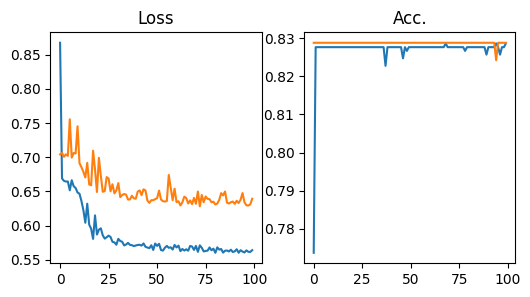

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # log
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

def train(model, epochs, train_loader, val_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss() # Softmax + NLLLoss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer, device)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn, device)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()

    # Save model
    # torch.save(model, MODEL_PATH)

train(model, 100, train_loader, val_loader)

#### Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
model.eval()
model.to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(val_loader):
        x, y = data
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred)
        y_true.append(y)

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
y_pred = y_pred.argmax(1).cpu().numpy()
y_true = y_true.numpy()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       363
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        29

    accuracy                           0.83       438
   macro avg       0.17      0.20      0.18       438
weighted avg       0.69      0.83      0.75       438



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
